# Foundations of Data Mining: Assignment 4

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

**Deadline:** Thursday, April 12, 2018

In [1]:
# Please fill in your names here
NAME_STUDENT_1 = "Iggy Van Hoof"
NAME_STUDENT_2 = "Ylja Remmits"

In [2]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

###### Backpropagation (6 points)

Figure 1 illustrates a simple neural network model.

![Figure 1](images/a4_network.png)

It has single input $x$, and three layers with respectively one, two, and one neurons. The activation function of the neurons is ReLU. 

The parameters $w_1$, $w_2$, $w_3$, $w_4$, and $w_5$ (no biases) are initialized to the following values $w_1 = 2, w_2 = 1$, $w_3 = 2$, $w_4 = 4$, and $w_5 = 1$. Implement a single update step of the gradient descent algorithm by hand. Run the update state for the data point $(x=2, y=3)$:

The goal is to model the relationship between two continuous variables. The learning rate is set to $0.1$

Provide the solution in the following format:

- A choice for a loss function 
- Compute graph for training the neural network
- Partial derivative expression for each of the parameters in the model
- The update expression for each of the parameters for each of the data-points
- The final value of all five parameters after the single step in the gradient descent algorithm

The Python code for simple computational graph nodes, as seen in the tutorial session, is provided in the cell below (run the cell to load the code, and again to run the code). Extend the nodes so they can be used to implement the network described above. Implement the network with the same initial weights and the correct learning rate, and verify your hand-made calculations. Add comments to your code or provide a separate description to explain the changes you have made.

In [3]:
# %load basic_graph.py
'''
Implementations of nodes for a computation graph. Each node
has a forward pass and a backward pass function, allowing
for the evaluation and backpropagation of data.
'''

from abc import ABC, abstractmethod
import math
import time


class Node(object):

    def __init__(self, inputs):
        self.inputs = inputs

    @abstractmethod
    def forward(self):
        ''' Feed-forward the result '''
        raise NotImplementedError("Missing forward-propagation method.")

    @abstractmethod
    def backward(self, d):
        ''' Back-propagate the error
            d is the delta of the subsequent node in the network '''
        raise NotImplementedError("Missing back-propagation method.")


class ConstantNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        pass


class VariableNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        self.output -= 0.1 * d # Gradient Descent


class AdditionNode(Node):

    def forward(self):
        self.output = sum([i.forward() for i in self.inputs])
        return self.output

    def backward(self, d):
        for i in self.inputs:
            i.backward(d)


class MultiplicationNode(Node):

    def forward(self):
        self.output = self.inputs[0].forward() * self.inputs[1].forward()
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.inputs[1].output)
        self.inputs[1].backward(d * self.inputs[0].output)


class MSENode(Node):

    def forward(self):
        self.output = 0.5 * (
            self.inputs[0].forward() - self.inputs[1].forward())**2
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * (self.inputs[0].output - self.inputs[1].output))
        self.inputs[1].backward(d * (self.inputs[1].output - self.inputs[0].output))


class SigmoidNode(Node):

    def forward(self):
        self.output = 1.0 / (1.0 + math.exp(-self.inputs[0].forward()))
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.output * (1.0 - self.output))

class ReLUNode(Node):

    def forward(self):
        self.output = max(0, self.inputs[0].forward())
        return self.output
#       Forward calculation for the ReLu function. 
#       It is 0 if the (already summed) inputs are lower than 0 or equal to the inputs otherwise.
    def backward(self, d):
        if self.output > 0:
            self.inputs[0].backward(d*1)
        else:
            self.inputs[0].backward(d*0)
#       By definition the ReLu function has a gradient of 0 for all values <0 and a gradient of 1 for values >0
#       For 0 there is no gradient, we decided to assign a gradient of 0 in this case.

class TanhNode(object):

    def forward(self):
        raise NotImplementedError("Forward pass for tanh activation node has not been implemented yet.")

    def backward(self, d):
        raise NotImplementedError("Backward pass for tanh activation node has not been implemented yet.")

# Example graph as shown in MLP lecture slides
class SampleGraph(object):

    def __init__(self, x, y, w, b):
        ''' x: input
            y: expected output
            w: initial weight
            b: initial bias '''
        self.w = VariableNode(w)
        self.b = VariableNode(b)
        self.graph = MSENode([
            AdditionNode([
                MultiplicationNode([
                    ConstantNode(x),
                    self.w
                ]),
                MultiplicationNode([
                    self.b,
                    ConstantNode(1)
                ])
            ]),
            ConstantNode(y)
        ])

    def forward(self):
        return self.graph.forward()

    def backward(self, d):
        self.graph.backward(d)


class Neuron(Node):

    def __init__(self, inputs, weights, activation):
        ''' weights: list of initial weights, same length as inputs '''
        self.inputs = inputs
        # Initialize a weight for each input
        self.weights = [VariableNode(weight) for weight in weights]
        # Neurons normally have a bias, ignore for this assignment
        #self.bias = VariableNode(bias, "b")

        # Multiplication node for each pair of inputs and weights
        mults = [MultiplicationNode([i, w]) for i, w, in zip(self.inputs, self.weights)]
        # Neurons normally have a bias, ignore for this assignment
        #mults.append(MultiplicationNode([self.bias, ConstantNode(1)]))

        # Sum all multiplication results
        added = AdditionNode(mults)

        # Apply activation function
        if activation == 'sigmoid':
            self.graph = SigmoidNode([added])
        elif activation == 'relu':
            self.graph = ReLUNode([added])
        elif activation == 'tanh':
            self.graph = TanhNode([added])
        else:
            raise ValueError("Unknown activation function.")

    def forward(self):
        self.output = self.graph.forward() # added in order to facilitate recusive backward pass calculations
        return self.output 

    def backward(self, d):
        self.graph.backward(d)

    def set_weights(self, new_weights):
        for i in len(new_weights):
            self.weights[i].output = new_weights[i]

    def get_weights(self):
        return [weight.output for weight in self.weights]

if __name__ == '__main__':
    print("Loaded simple graph nodes")
    inputs = [ConstantNode(2)]
#   Init neurons with weigths and do forward pass
    n1 = Neuron(inputs, [2], 'relu')
    o1 = n1.forward()
    n2 = Neuron([n1], [1], 'relu')
    n3 = Neuron([n1], [2], 'relu')
    o2 = n2.forward()
    o3 = n3.forward()
    n4 = Neuron([n2, n3], [4, 1], 'relu')
    o4 = n4.forward()
    mse = MSENode([n4, ConstantNode(3)]) # end forward pass
    
    gMSE = mse.backward(1) #recusive backwardpass
    print("w1: {}".format(n1.get_weights()[0]))
    print("w2: {}".format(n2.get_weights()[0]))
    print("w3: {}".format(n3.get_weights()[0]))
    print("w4: {}".format(n4.get_weights()[0]))
    print("w5: {}".format(n4.get_weights()[1]))
  
    # Example network
#     sg = SampleGraph(2, 2, 2, 1)
#     prediction = sg.forward()
#     print("Initial prediction is", prediction)
#     sg.backward(1)
#     print("w has new value", sg.w.output)
#     print("b has new value", sg.b.output)

    # Run your network here

'\nImplementations of nodes for a computation graph. Each node\nhas a forward pass and a backward pass function, allowing\nfor the evaluation and backpropagation of data.\n'

Loaded simple graph nodes
w1: -23.200000000000003
w2: -32.6
w3: -6.4
w4: -4.4
w5: -15.8


#### Manual calculations
We start with the manual calculations. $(x=2,y=3)$ and $(w_1,w_2,w_3,w_4,w_5)=(2,1,2,4,1)$. The forward calculations are straightforward: $n_1=\max(w_1\times x=2\times 2,0)=4$, $n_2=\max(w_2\times n_1,0)=4$, $n_3=\max(w_3\times n_1,0)=8$, $n_4=\max(n_2\times w_4 + n_3\times w_5,0)=24$. Finally, the MSE is $\frac{1}{2}(n_4-y)^2=\frac{1}{2}(24-3)^2=220.5$

The backwards calculations are similar to the examples from the slides:
$$
\begin{align}
\frac{\delta L}{\delta L}&=1&&\\
\frac{\delta L}{\delta n_4}&=\frac{\delta}{\delta n_4}\frac{1}{2}(n_4-y)^2&=n_4-y&\\
\frac{\delta L}{\delta w_5}&=\frac{\delta L}{\delta n_4}\frac{\delta n_4}{\delta w_5}&=n_3(n_4-y)&=168\\
\frac{\delta L}{\delta w_4}&=\frac{\delta L}{\delta n_4}\frac{\delta n_4}{\delta w_4}&=n_2(n_4-y)&=84\\
\frac{\delta L}{\delta w_3}&=\frac{\delta L}{\delta n_4}\frac{\delta n_4}{\delta n_3}\frac{\delta n_3}{\delta w_3}&=w_5n_1(n_4-y)&=84\\
\frac{\delta L}{\delta w_2}&=\frac{\delta L}{\delta n_4}\frac{\delta n_4}{\delta n_2}\frac{\delta n_2}{\delta w_2}&=w_4n_1(n_4-y)&=336\\
\frac{\delta L}{\delta w_1}&=\frac{\delta L}{\delta n_4}\frac{\delta n_4}{\delta n_2}\frac{\delta n_2}{\delta n_1}\frac{\delta n_1}{\delta w_1} + \frac{\delta L}{\delta n_4}\frac{\delta n_4}{\delta n_3}\frac{\delta n_3}{\delta n_1}\frac{\delta n_1}{\delta w_1}&=(w_5w_3+w_4w_2)x(n_4-y)&=252
\end{align}
$$
These only hold for variables and input which are positive. Using ReLU, the proper value of, for example, $\frac{\delta n_4}{\delta w_5}$ would be 0 for $n_3\times w_5<0$ and $n_3$ for $n_3\times w_5 > 0$, with no proper solution at 0 (we'll say that it is 0 in that case). However, all our products are positive.

We then calculate the updated $w_i$ with $i=1,2,3,4,5$ using $w_i\leftarrow w_i-\alpha\frac{\delta L}{\delta w_i}$:
$$\begin{align}
(w_1,w_2,w_3,w_4,w_5)&\leftarrow& (2-0.1\times252,1-0.1\times336,2-0.1\times84,4-0.1\times84,1-0.1\times168)\\
&=&(-23.2,-32.6,-6.4,-4.4,-15.8)
\end{align}$$


## Training Deep Models (3 points)

The model in the example code below performs poorly as its depth increases. Train this model on the MNIST digit detection task. 

Examine its training performance by gradually increasing its depth:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Modify the model such that you improve its performance when its depth increases. Train the new model again for the different depths:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Submit an explanation for the limitation of the original model. Explain your modification. 
Submit your code and 6 plots (can be overlaid) for the training performance of both models with different depths. 



In [5]:
# (You don't need to change this part of the code)
from __future__ import print_function
import numpy as np
np.random.seed(1234)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils


import matplotlib.pyplot as plt

batch_size = 128
nb_classes = 10
nb_epoch = 10

Using TensorFlow backend.


In [6]:
# (You don't need to change this part of the code)
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

60000 train samples
10000 test samples


In [7]:
# Use this parameter to change the depth of the model
number_hidden_layers_max = 3  # Number of hidden layers

In [8]:
# Model
scores = []
histories = []
scores2 = []
histories2 = []
for i in range(1,number_hidden_layers_max+1):
    # Improved model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,), activation='relu'))
    model.add(Dropout(0.2))
    
    number_hidden_layers = i
    while number_hidden_layers > 1:
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
        number_hidden_layers -= 1


    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

    
    histories.append(model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test)))
    scores.append(model.evaluate(X_test, Y_test, verbose=0))
    
    # Old model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,), activation='sigmoid'))
    model.add(Dropout(0.2))
    
    number_hidden_layers = i
    while number_hidden_layers > 1:
        model.add(Dense(512))
        model.add(Activation('sigmoid'))
        model.add(Dropout(0.2))
        number_hidden_layers -= 1


    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

    
    histories2.append(model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test)))
    scores2.append(model.evaluate(X_test, Y_test, verbose=0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 94us/step - loss: 1.0992 - acc: 0.7421 - val_loss: 0.5944 - val_acc: 0.8676
Epoch 2/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 153us/step - loss: 2.3313 - acc: 0.1205 - val_loss: 2.2290 - val_acc: 0.4042
Epoch 2/10
60000/60000 [==============================] - 9s 146us/step - loss: 2.2519 - acc: 0.1677 - val_loss: 2.1458 - val_acc: 0.4069
Epoch 3/10
60000/60000 [==============================] - 9s 147us/step - loss: 2.1547 - acc: 0.2420 - val_loss: 2.0360 - val_acc: 0.4518
Epoch 4/10
60000/60000 [==============================] - 9s 146us/step - loss: 2.0284 - acc: 0.3344 - val_loss: 1.8814 - val_acc: 0.6612
Epoch 5/10
60000/60000 [==============================] - 9s 146us/step - loss: 1.8620 - acc: 0.4225 - val_loss: 1.6759 - val_acc: 0.7004
Epoch 6/10
60000/60000 [==============================] - 9s 146us/step - loss: 1.6595 - acc: 0.5015 - val_loss: 1.4501 - val_acc: 0.7443
Epoch 7/10
60000/60000 [==============================] - 9s 146us/step - loss: 1.4536 - acc: 0.5671 - val_loss: 1.2463 - 

Test score for relu, 1 hidden layer(s): 0.2578086549937725
Test accuracy for relu, 1 hidden layer(s): 0.9272
Test score for sigmoid, 1 hidden layer(s): 0.4686168270349503
Test accuracy for sigmoid, 1 hidden layer(s): 0.882
Test score for relu, 2 hidden layer(s): 0.20732052508294582
Test accuracy for relu, 2 hidden layer(s): 0.9388
Test score for sigmoid, 2 hidden layer(s): 0.8513774814605712
Test accuracy for sigmoid, 2 hidden layer(s): 0.8037
Test score for relu, 3 hidden layer(s): 0.18089818385243417
Test accuracy for relu, 3 hidden layer(s): 0.9449
Test score for sigmoid, 3 hidden layer(s): 2.2314222877502443
Test accuracy for sigmoid, 3 hidden layer(s): 0.2659


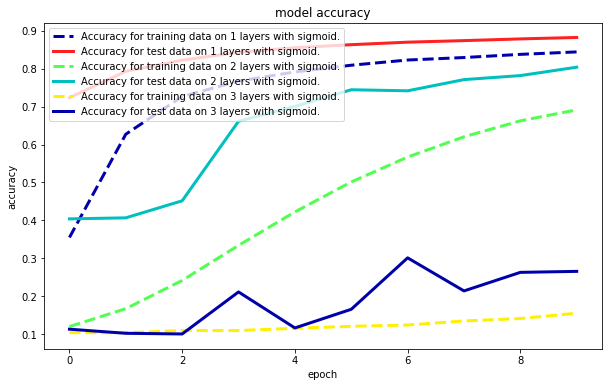

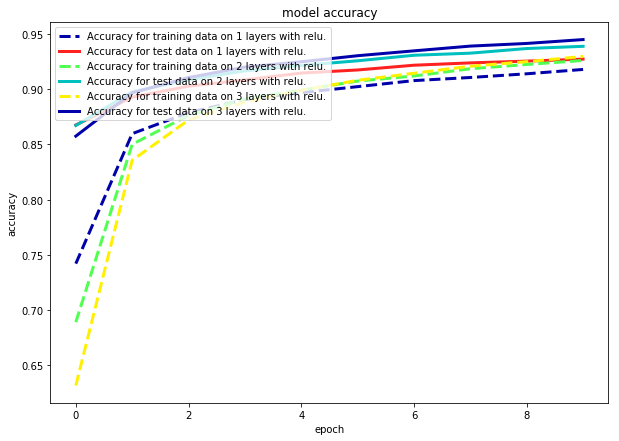

In [19]:
# Training (You don't need to change this part of the code)
for i in range(3):
    print('Test score for relu, {} hidden layer(s): {}'.format(i+1, scores[i][0]))
    print('Test accuracy for relu, {} hidden layer(s): {}'.format(i+1, scores[i][1]))
    print('Test score for sigmoid, {} hidden layer(s): {}'.format(i+1, scores2[i][0]))
    print('Test accuracy for sigmoid, {} hidden layer(s): {}'.format(i+1, scores2[i][1]))

plt.figure(figsize=(10,6));
for i in range(len(histories)):
    plt.plot(histories2[i].history['acc'], ls='dashed', lw=3,label = "Accuracy for training data on {} layers with sigmoid.".format(i+1));
    plt.plot(histories2[i].history['val_acc'], ls='solid', lw=3, label = "Accuracy for test data on {} layers with sigmoid.".format(i+1));
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(loc='upper left');
plt.show();

plt.figure(figsize=(10,7));
for i in range(len(histories)):
    # summarize history for accuracy
    plt.plot(histories[i].history['acc'], ls='dashed', lw=3, label = "Accuracy for training data on {} layers with relu.".format(i+1));
    plt.plot(histories[i].history['val_acc'], ls='solid', lw=3, label = "Accuracy for test data on {} layers with relu.".format(i+1));

plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(loc='upper left');
plt.show();



#### Explanation:
We can see that for the initial model accuracy becomes worse for more layers. This can be explained by the vanishing gradient problem. Where the gradient visible a the output node, goes to zero in earlier layers. This is a problem that comes with the sigmoid function. When instead of the sigmoid activation function we use a ReLu function, this problem is solved.

## MNIST Calculator (6 points)

During the lectures you have seen a CNN model that can be successfully trained to classify the MNIST images. You have also seen how a RNN model that can be trained to implement addition of two numbers. You now need to build a model that is a combination of convolutional layers and recurrent cells. 

Using the KERAS library, design and train a model that produces a sum of a sequence of MNIST images. More specifically, the model should input a sequence of 10 images and compute the cumulative sum of the digits represented by the images.

For example:

Input 1: ![294](images/a3ex1.png)

Output 1: 46

Input 2: ![61](images/a3ex2.png)

Output 2: 43

Your solutions should include:
- Python code that formats the MNIST dataset such that it can be used for traning and testing your model
- Implementation in keras of your model (for training and testing)
- Performance on the model on test data
- Justification (in text) of your decisions for the model architecture (type of layers, activation functions, loss function, regularization and training hyperparameters)

Note: Use the 60000/10000 train/test split of the MNIST dataset


In [11]:
# Provide your solution here
import math
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
import keras
from six.moves import range
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, TimeDistributed
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras import backend as K
from keras.layers import RNN, RepeatVector

from keras.layers.core import  Activation
from keras.optimizers import SGD
from keras.utils import np_utils

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
import numpy as np

batch_size = 128
nb_classes = 10
nb_epoch = 15
img_rows = 28
img_columns = 28
sumlength = 10
HIDDEN_SIZE = 128
LAYERS=1

In [16]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#change the data to be the right shape for sum calculation
X_train = X_train.reshape(6000, sumlength, img_rows, img_columns, 1)
X_test = X_test.reshape(1000, sumlength, img_rows, img_columns, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = y_train.reshape(6000, sumlength)
Y_test = y_test.reshape(1000, sumlength)

Y_train = sum(Y_train.T).reshape(6000,1)
Y_test = sum(Y_test.T).reshape(1000,1)
Y_train = np.concatenate((((Y_train-(Y_train%10))/10), (Y_train%10)), axis=1)
Y_test = np.concatenate((((Y_test-(Y_test%10))/10), (Y_test%10)), axis=1)

Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)


6000 train samples
1000 test samples


In [13]:
RNN = layers.LSTM

model = Sequential()
#add the cnn layers
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=X_train.shape[1:]))
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(512, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(nb_classes)))
model.add(TimeDistributed(Activation('softmax')))

#add the rnn layers over every set of 10 x
model.add(RNN(HIDDEN_SIZE))
model.add(RepeatVector(2))
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far. 
    # This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(10)))
#we use the softmax activation function
model.add(layers.Activation('softmax'))
#we use the cross entropy loss function
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 28, 28, 32)    320       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 26, 26, 32)    9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 13, 13, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 13, 13, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 13, 13, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 11, 11, 64)    36928     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 5, 5, 64)      0         
__________

In [14]:
#collect the loss etc with each step
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

lh = LossHistory()
# Training loop
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[lh])
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 6000 samples, validate on 1000 samples
Epoch 1/15
6000/6000 [==============================] - 208s 35ms/step - loss: 2.2275 - acc: 0.2450 - val_loss: 2.1319 - val_acc: 0.2590
Epoch 2/15
6000/6000 [==============================] - 206s 34ms/step - loss: 2.1284 - acc: 0.2479 - val_loss: 1.9821 - val_acc: 0.2590
Epoch 3/15
6000/6000 [==============================] - 215s 36ms/step - loss: 1.9157 - acc: 0.2501 - val_loss: 1.8348 - val_acc: 0.2675
Epoch 4/15
6000/6000 [==============================] - 213s 36ms/step - loss: 1.8683 - acc: 0.2503 - val_loss: 1.8370 - val_acc: 0.2730
Epoch 5/15
6000/6000 [==============================] - 209s 35ms/step - loss: 1.8649 - acc: 0.2507 - val_loss: 1.8388 - val_acc: 0.2730
Epoch 6/15
6000/6000 [==============================] - 218s 36ms/step - loss: 1.8621 - acc: 0.2498 - val_loss: 1.8249 - val_acc: 0.2970
Epoch 7/15
6000/6000 [==============================] - 217s 36ms/step - loss: 1.8599 - acc: 0.2519 - val_loss: 1.8287 - val_acc: 

##### Justification

We can see that the accuracy of our model is only about 25%. We could potentially improve this by adding more layers or increasing the sample size, as the sum of 10 uniformly random integers is not a uniformly random integer and some classes might be underpopulated (for example, the sum total 1 is 10 times more common than sum total 0). We built our model by doing a similar cnn to the previous exercise with same hyperparameters, doing them in series of 10. Then we apply the RNN twice and make sure every 10 numbers correspond to 1 sum. We use cross entropy for loss as it interacts well with the many different classes. We use the ReLU nodes for the same reason as the previous exercise.